# Netgen-Poreflow
**Simulating fluid flow in porous media using Poreflow and Netgen porenetwork modeling package**

###### Author : Misagh Esmaeilpour (misagh@ksu.edu)

###### Semester: Spring 2020
 
---

A brief overview of what the following code snippets aim to do is provided <a href="https://raw.githubusercontent.com/misagh-esmaeilpour/netgen-poreflow/master/proposal.md" title="proposal">here</a>.

The package that we are using for our simulations was developed by Per Valvatne (2004) which is written in C++ and you can <a href="http://www.imperial.ac.uk/earth-science/research/research-groups/perm/research/pore-scale-modelling/software/two-phase-network-modelling-code/" title="download_link"> download</a> all the executable files and manuals directly from the website of Imperial College London.

`netgen_32.exe` is the executable file that generates our porenetworks. This file gets a `.dat` file as an input. This input file consist of all the properties that we want to assign to our porenetworks such as network size, length of pore throats, etc. In our simulations this file is `netgenInput.dat` and since we want to change network size of porenetworks in our simulations we have to create a new `netgenInput.dat` file each time we change this parameter. All information of porenetworks would be saved in four `.dat` files with a prefix that we define for it in `netgenInput.dat`(here I use Porenetworks).

`poreflow_32.exe` is the executable file that simulates fluid flow through our generated porenetwork and it gets a `.dat` file as an input too, which would be `poreflowInput.dat` in our simulations. This input file consists of all the properties that we want to assign to our fluid and flow mechanism. In our study all these properties are constant and therefore we will use our pre-written `poreflowInput.dat` for all the simulations.  After running `poreflow_32.exe` all the results will be saved as texts in a file with `.prt` extension (this file would have the same name as the input file for `poreflow_32.exe`, so in our simulations it would be `poreflowInput.prt`  . Therefore we will read this file and extract our desired values which would be permeability, porosity and formation factor out of it.
Two other files with a `.out` extension also would be outputed that contain other information such as draining cycle and imbibition cycle, but we are not working with these files.

**Note:** If you need to modify your `poreflowInput.dat` for your simulations, you could easily follow the same steps that we have done to modify `netgenInput.dat` and add it to your code.

<p>
    <img src="../Pictures/workflow.jpg" alt="Fig.2" width="700"/>
</p>
<p>
    <em>Fig.1: The workflow of the project </em>
</p>

In [39]:
#importing required modules
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pandas as pd

First we define a list of the network sizes that we want to simulate and number of iterations for each of the networks.
By network size we mean that how many pores we have in each of the three primary directions. For instance the porenetwork shown in the picture below is of size 3, and has 3 * 3 * 3 = 27 pores in it.

<p>
    <img src="../Pictures/pnm.jpg" alt="Fig.2" width="200"/>
</p>
<p>
    <em>Fig.2: A porenetwork of size 3 (after De La Garza Martínez, 2016) </em>
</p>

In [100]:
start_time= datetime.datetime.now()

networks_sizes = [10, 15, 20] # A list of network sizes for simulations
iteration = 2 # Number of iterations

In [ ]:
OneDrive - Kansas State University/Spring 2020/agron935/project/netgen-poreflow/pictures/workflow.jpg

At the code snippet below we have also defined the three arrays that will store all of our desired vaules out of simulations.

In [29]:
# Defining three arrays to store simulation data in them:
permeability_array = np.zeros((len(networks_sizes),len(range(iteration))))
formationfactor_array = np.zeros((len(networks_sizes),len(range(iteration))))
porosity_array = np.zeros((len(networks_sizes),len(range(iteration))))

The only parameter that is changed in the "netgenInput.dat" is network size.
This lambda function will allow us to change network size. Its input argument would be an string like "20 20 20".
The lambda function defined below takes an string of network size as input and puts it into the list that we will use to create our `netgenInput.dat`.

In [30]:
net_input = lambda network : ["Porenetworks % Base file \n",
        network,"\n",
        "0.1 10 0.2 6 % Min throat radius, max throat radius, delta exp, eta exp \n",
        "100 100 0.3 2.0 % Min throat length, max throat length, delta exp, eta exp \n",
        "0 0 0.2 3.0 % Min aspect ratio, max aspect ratio, delta exp, eta exp \n",
        "0.001 0.04811 0.8 1.6 % Triangles: Min G, max G, delta exp, eta exp \n",
        "0 1 % Pores: proportion of square and circular pores \n",
        "0 1 % Throats: proportion of square and circular throats \n",
        "0 % Proportion of pore volume occupied by clay \n",
        "6 % Average connection number <= 6 \n",
        "T % Use periodic boundary conditions \n"]

In the following code snippet, we write `netgenInput.dat` and then will generate porenetworks and right after that simulationg the flow through them starts.
Our values of interest would be saved in a .prt (poreflowInput.prt) file that  "preflow_32.exe" outputs. And we can easily read these values from this file.
Based on experience working with this package we know that porosity, permeability, and formation factor would saved respectively on either lines 22, 25, and 26 or 30, 33, and 34. Also sometimes because of the heavy computations poreflow crashes and will not output anythin. Hence, we handle all three scenarios in the code below.

In [31]:
# outer for loop changes the network size and inner for loop does the iterations
for i in range(len(networks_sizes)):
    for j in range(iteration):
        #creating network size string 
        network_3d= (str(networks_sizes[i])+ " ")*3
        input_text= net_input(network_3d)
        
        # writing input_text in 'netgenInput.dat'
        f= open("netgenInput.dat","w")
        f.writelines(input_text)
        f.close()
        
        # generating pore networks
        os.system("netgen_win32.exe netgenInput.dat")
        
        # simulating flow through generated porenetworks
        os.system("poreflow_win32.exe poreflowInput.dat")
        
        # reading the .prt output file from poreflow into separated lines
        output = open("poreflowInput.prt")
        output_lines = output.readlines()
        
        # putting NaN in case poreflow crashes and does not create the output file completely
        if len(output_lines) < 26:
            permeability_array[i][j] = np.nan
            porosity_array[i][j] = np.nan
            formationfactor_array[i][j] = np.nan
            
        # reading values from the output    
        elif "permeability" in output_lines[25].split():
            permeability_line = output_lines[25].split()
            permeability_array[i][j] = permeability_line[-1]
            porosity_line = output_lines[22].split()
            porosity_array[i][j] = porosity_line[-1]
            formationfactor_line = output_lines[26].split()
            formationfactor_array[i][j] = formationfactor_line[-1]
        else:
            permeability_line = output_lines[33].split()
            permeability_array[i][j] = permeability_line[-1]
            porosity_line = output_lines[30].split()
            porosity_array[i][j] = porosity_line[-1]
            formationfactor_line = output_lines[34].split()
            formationfactor_array[i][j] = formationfactor_line[-1]


After storing the desired values of all iterations, we get a mean value of all iterations per network size for each of the three arrays, and will use the mean value as the representative value for that variable. For insatace we would have a value that represents permeability for network size of 10, another one for 20 and so on.

In [32]:
# getting mean values for each network size for permeability, porosity, and formation factor
permeability_means = np.nanmean(permeability_array, axis=1)
formationfactor_means = np.nanmean(formationfactor_array, axis=1)
porosity_means = np.nanmean(porosity_array, axis=1)

Plots below show that how values of permeability, porosity and, formation factor when we change the size of our porenetworks.



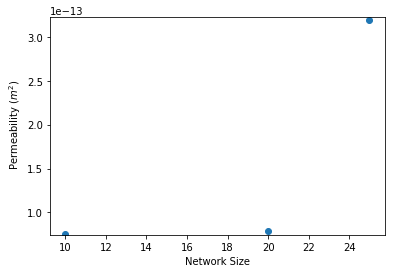

In [33]:
plt.scatter(networks_sizes, permeability_means)
plt.xlabel('Network Size')
plt.ylabel(' Permeability $(m^{2}$)')
plt.ylim(0.99*min(permeability_means), 1.01*max(permeability_means))
plt.show()

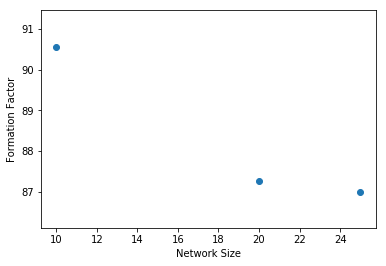

In [34]:
plt.scatter(networks_sizes, formationfactor_means)
plt.xlabel('Network Size')
plt.ylabel('Formation Factor')
plt.ylim(0.99*min(formationfactor_means), 1.01*max(formationfactor_means))
plt.show()

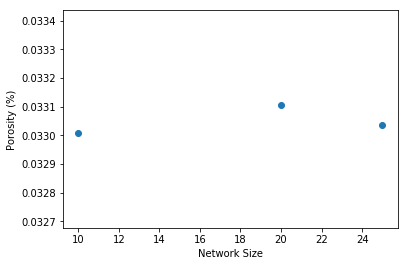

In [35]:
plt.scatter(networks_sizes, porosity_means)
plt.xlabel('Network Size')
plt.ylabel('Porosity (%)')
plt.ylim(0.99*min(porosity_means), 1.01*max(porosity_means))
plt.show()

Now we save these variables into a `.csv` file. Name of it would the date and time when the code was started to run, and the file would be saved in a folder named `csv_output`in the current directory.


In [107]:
#creating a dictionary of the data to then convert it to a pandas dataframe
data = {'Network Size':networks_sizes, 'Permeability $(m^{2}$)': permeability_means,'Porosity (%)':porosity_means, 'Formation Factor':formationfactor_means}
#creating a pandas dataframe out of data
df = pd.DataFrame(data)

#creating the 'csv_output' directory if it does not exists already
if os.path.isdir('csv_output') == False:
    os.mkdir('csv_output')
    
#creating the name of the csv file
file_name = start_time.strftime("%Y-%m-%d-%H-%M-%S") + '.csv'
print('The output file name is:',file_name)

#exporting the dataframe into a csv file
file_path = 'csv_output/'+ file_name 
df.to_csv(file_path, index=False)
df.head(3)


The output file name is: 2020-05-04-21-22-35.csv


,Network Size,Permeability $(m^{2}$),Porosity (%),Formation Factor
0,10,7.532875e-14,0.033008,90.55305
1,15,3.189048e-13,0.033036,86.98630
2,20,7.835405e-14,0.033105,87.26550


In [138]:
endtime= datetime.datetime.now()
endtime -start_time

datetime.timedelta(seconds=63, microseconds=932687)

In [ ]:
# Matlab took around 4200 seconds

# 5 iter : 100.991184 sec
# 10  212.362963 seconds.
# 15  316.705312
# 20  414.290092
# 25  517.466775
# 30  629.508653


##### Conclusion:

As we saw in the above figures we can conclude that by increasing the size of the porenetworks we have an increase in permeability while 

#### References:
1. Valvatne, P. H. (2004). Predictive pore-scale modelling of multiphase flow (Doctoral dissertation, Department of Earth Science and Engineering, Imperial College London).
2. De La Garza Martínez, P. A. (2016). Pore Network Modeling: Alternative Methods to Account for Trapping and Spatial Correlation. (May), 72.